# Udacity Data Science Nanodegree Project 1 Term 2
## Write a Data Science Blog Post
### Seattle Airbnb Open Data

In [2]:
# Packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Own defined functions

In [3]:
def char_eraser(string, character):
    """The functions takes a string, substracts the character passed as an argument and 
    returns the result as an int. """
    if pd.isna(string):
        value = np.nan
    else:
        value = float(string.replace(character, ''))
    
    return value

def price_converter(string):
    """The function takes a number formated as a string that ends with a dolar symbol ($) and erases the symbol. 
     the number has decimals delimited by a comma ',' it  
    """
    if isinstance(string, str):
        value = float(string.replace('$', '').replace(',', ''))
    else:
        value = string
    
    return value

def is_holidays(date):
    '''Checks if the date is a Seattle holiday'''
    holidays_2016 = ['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', 
                     '2016-11-11', '2016-11-24', '2016-11-25', '2016-12-26', '2017-01-01']
    
    if isinstance(date, pd.Timestamp):
        date = date.strftime('%Y-%m-%d')
    
    holiday = True if date in holidays_2016 else False
    
    return holiday

## Data Import

In [4]:
calendar = pd.read_csv('calendar_seattle.csv')
listings = pd.read_csv('listings_seattle.csv')
reviews = pd.read_csv('reviews_seattle.csv')

In [5]:
print(calendar.shape, listings.shape, reviews.shape)

(1393570, 4) (3818, 92) (84849, 6)


In [6]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [7]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [8]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


## Preprocess

In [14]:
calendar['price'] = calendar['price'].apply(price_converter)  # Formatting price column to number
calendar['available'] = calendar['available'].apply(lambda x: False if x == 'f' else True)  # Formatting available column to boolean
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['is_holiday'] = calendar['date'].apply(is_holidays)
calendar['weekday'] = calendar['date'].apply(lambda x: x.day_name())
calendar['is_friday_saturday'] = calendar['weekday'].apply(lambda x: 
                                                    True if x in ['Friday', 'Saturday'] else False)

In [10]:
calendar.head()

,listing_id,date,available,price,is_holiday,weekday,is_weekdend
0,241032,2016-01-04,True,85.0,False,Monday,False
1,241032,2016-01-05,True,85.0,False,Tuesday,False
2,241032,2016-01-06,False,NaN,False,Wednesday,False
3,241032,2016-01-07,False,NaN,False,Thursday,False
4,241032,2016-01-08,False,NaN,False,Friday,False


Percentage of missing values per column:

In [14]:
(len(calendar) - calendar.apply('count'))/len(calendar)*100

listing_id     0.000000
date           0.000000
available      0.000000
price         32.938998
dtype: float64

## Data Visualization

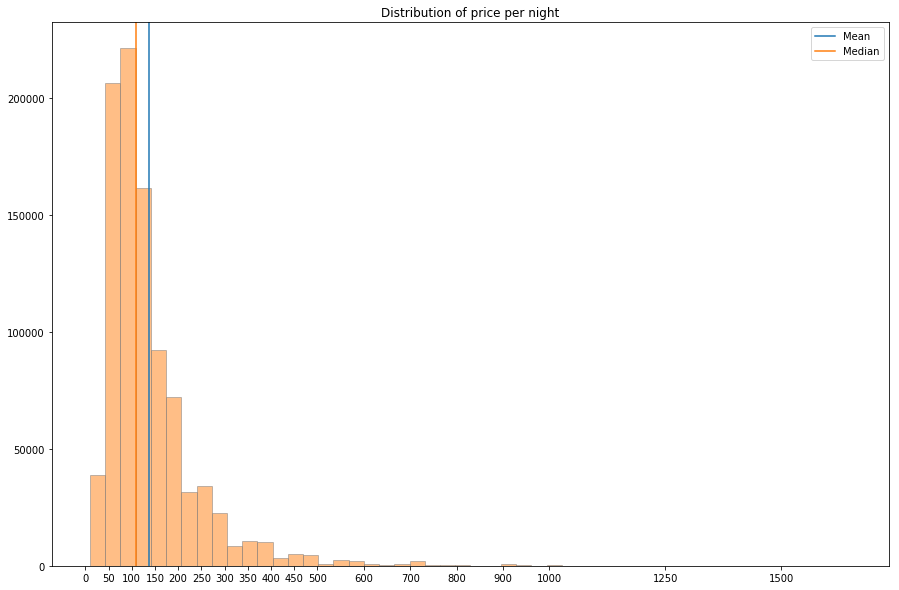

In [10]:
# bins = int(np.sqrt(len(calendar['price'].dropna())))
# print(bins)
available = calendar[calendar['available']]
unavailable = calendar[~calendar['available']]
plt.figure(figsize=(15,10))
plt.hist(calendar['price'].dropna(), bins=50, edgecolor='gray', color='C1', alpha=0.5)
plt.title('Distribution of price per night')
plt.xticks(list(range(0,501, 50)) + list(range(600,1001,100)) + [1250, 1500])
plt.axvline(x=calendar['price'].mean(), color='C0', label='Mean')
plt.axvline(x=calendar['price'].median(), color='C1', label='Median')
plt.legend()
plt.show()
# sns.distplot(available['price'].dropna(), kde=False,
#              kde_kws={'shade':True, 'bw':100, 'color':'C0'},
#              hist_kws={'color':'C1', 'edgecolor':'gray'}).set_title('Distribution of room prices');

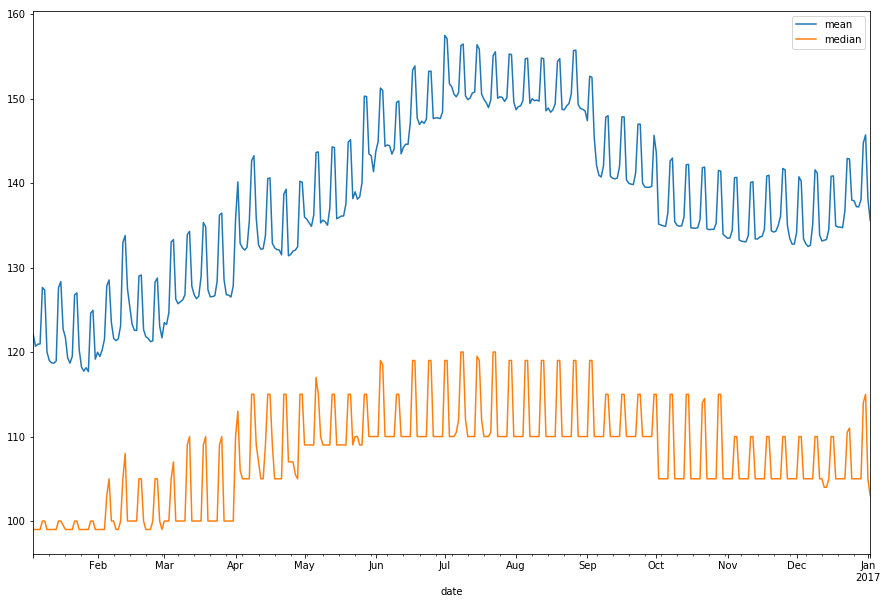

In [16]:
calendar.groupby('date')['price'].agg(['mean', 'median']).plot(figsize=(15,10))

/home/rubengura/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


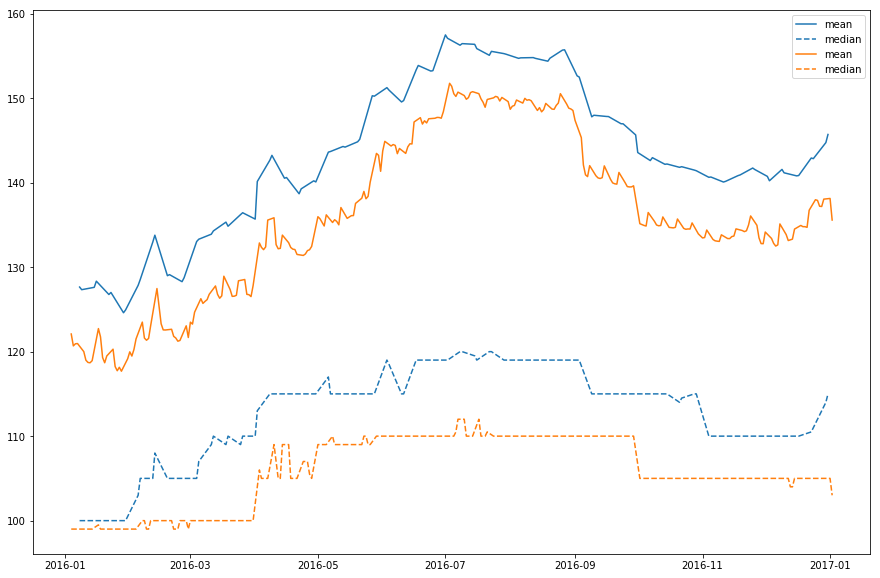

In [15]:
plt.figure(figsize=(15,10))
for pos, is_weekend in enumerate([True, False]):
    filt = calendar[calendar['is_friday_saturday']  == is_weekend].groupby('date')['price'].agg(['mean', 'median',
                                                                                        'min', 'max'])
    plt.plot(filt.index, filt['mean'], color='C'+str(pos))
    plt.plot(filt.index, filt['median'], color='C'+str(pos), linestyle='--')
    plt.legend()
plt.show()

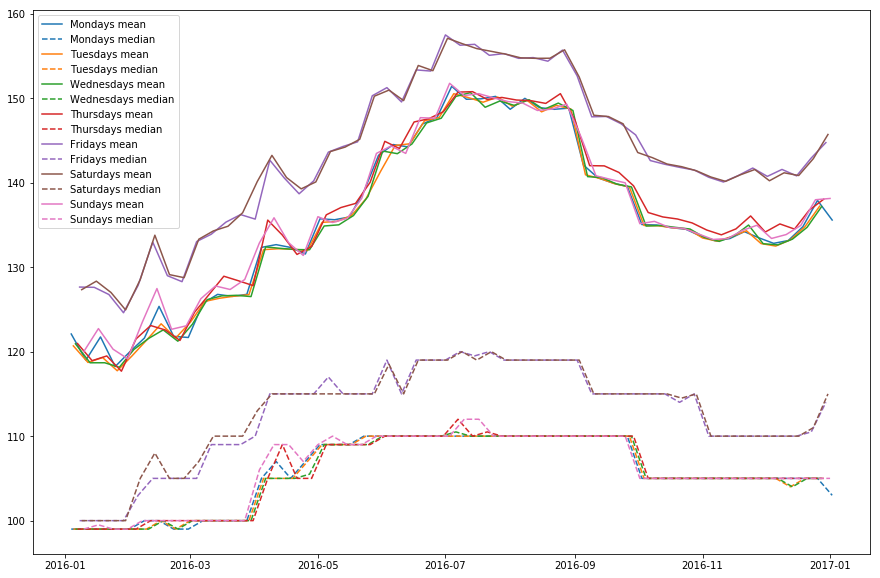

In [14]:
plt.figure(figsize=(15,10))
for pos, weekday in enumerate(calendar['weekday'].unique()):
    filt = calendar[calendar['weekday']  == weekday].groupby('date')['price'].agg(['mean', 'median'])
    plt.plot(filt.index, filt['mean'], color='C'+str(pos), label=weekday + 's mean')
    plt.plot(filt.index, filt['median'], color='C'+str(pos), linestyle='--', label=weekday + 's median')
    plt.legend()
plt.show()

In [39]:
min_date, max_date = available['date'].apply([np.min, np.max])

In [22]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [32]:
listings.groupby('host_id')[['price', 'weekly_price', 'monthly_price',
       'minimum_nights', 'maximum_nights','review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',]].agg([np.mean, np.std])

minimum_nights           maximum_nights              \
                   mean       std           mean         std   
host_id                                                        
4193           2.000000  0.000000     752.500000  516.405848   
6207           1.000000       NaN      14.000000         NaN   
8021           1.000000  0.000000    1125.000000    0.000000   
8993           3.000000       NaN      28.000000         NaN   
11775          2.000000       NaN    1125.000000         NaN   
14942          2.666667  0.577350     412.000000  618.439164   
19425          1.000000       NaN    1125.000000         NaN   
20731          1.000000  0.000000     567.500000  788.424061   
30559          2.000000  0.000000      36.000000   13.416408   
30604          2.000000       NaN      14.000000         NaN   
30832          3.000000  0.000000      29.000000    0.000000   
31481          2.500000  0.707107     365.000000    0.000000   
31509          1.000000  0.000000      27.250000    0.500000   
33360          2.600000  0.547723     723.000000  552.093742   
34943          7.000000       NaN      30.000000         NaN   
35749          2.000000  0.000000      60.000000    0.000000   
39377          1.000000  0.000000     861.666667  228.053356   
44907          1.000000       NaN      30.000000         NaN   
46879          2.000000       NaN       6.000000         NaN   
50893          2.400000  0.516398     276.600000  460.002464   
53050          5.000000  0.000000    1062.000000   89.095454   
58235          2.000000  0.000000     927.500000  279.307179   
62386          1.500000  0.577350     576.500000  633.353245   
64929          4.000000       NaN    1125.000000         NaN   
64955          2.000000       NaN       6.000000         NaN   
66145          1.333333  0.577350       6.666667    0.577350   
68155          1.000000       NaN    1125.000000         NaN   
68389          2.000000       NaN    1125.000000         NaN   
68641          2.000000       NaN     365.000000         NaN   
73359          3.000000  0.000000     607.500000  731.855519   
...                 ...       ...            ...         ...   
50554731       1.000000       NaN    1125.000000         NaN   
50557855       1.000000  0.000000    1125.000000    0.000000   
50586425       2.000000       NaN      31.000000         NaN   
50596206       1.000000       NaN    1125.000000         NaN   
50763436       2.000000       NaN    1125.000000         NaN   
50862682       2.000000       NaN    1125.000000         NaN   
50913131       2.500000  0.707107    1125.000000    0.000000   
50915624       1.000000       NaN    1125.000000         NaN   
50943410       4.000000       NaN    1125.000000         NaN   
50987314       3.000000       NaN      28.000000         NaN   
51081172       1.000000       NaN    1125.000000         NaN   
51256001       3.000000       NaN    1125.000000         NaN   
51344613       1.000000       NaN       4.000000         NaN   
51372899       2.000000       NaN    1125.000000         NaN   
51433714       3.000000       NaN    1125.000000         NaN   
51461746       1.000000       NaN      60.000000         NaN   
51554113       1.000000       NaN    1125.000000         NaN   
51860756       1.000000       NaN    1125.000000         NaN   
51875760       1.000000       NaN    1125.000000         NaN   
51946984       1.000000       NaN    1125.000000         NaN   
52012565       2.000000       NaN    1125.000000         NaN   
52463088       2.000000       NaN       7.000000         NaN   
52580911       1.000000       NaN    1125.000000         NaN   
52603251       1.000000       NaN    1125.000000         NaN   
52791370       1.000000       NaN       7.000000         NaN   
52990042       1.000000       NaN    1125.000000         NaN   
53050379       1.000000       NaN    1125.000000         NaN   
53065829       2.000000       NaN    1125.000000         NaN   
53169216       1.000000       NaN    1125

In [47]:
listings_vars_to_merge = listings[['id', 'neighbourhood', 'neighbourhood_cleansed', 'experiences_offered',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet','minimum_nights', 'maximum_nights',
       'review_scores_rating', 'review_scores_accuracy']]

In [48]:
ml_data = pd.merge(calendar, listings_vars_to_merge, left_on='listing_id', right_on='id')

In [7]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [8]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


### Preprocessing

In [9]:
listings.loc[:,listings.columns.str.match('host')]

,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified
0,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t
1,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t
2,16708587,https://www.airbnb.com/users/show/16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,f,https://a1.muscache.com/ac/users/16708587/prof...,https://a1.muscache.com/ac/users/16708587/prof...,Queen Anne,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t
3,9851441,https://www.airbnb.com/users/show/9851441,Emily,2013-11-06,"Seattle, Washington, United States",NaN,NaN,NaN,NaN,f,https://a2.muscache.com/ac/users/9851441/profi...,https://a2.muscache.com/ac/users/9851441/profi...,Queen Anne,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t
4,1452570,https://www.airbnb.com/users/show/1452570,Emily,2011-11-29,"Seattle, Washington, United States","Hi, I live in Seattle, Washington but I'm orig...",within an hour,100%,NaN,f,https://a0.muscache.com/ac/users/1452570/profi...,https://a0.muscache.com/ac/users/1452570/profi...,Queen Anne,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t
5,326758,https://www.airbnb.com/users/show/326758,Andrew,2010-12-25,"Seattle, Washington, United States",I've been fortunate to have had many life expe...,NaN,NaN,NaN,f,https://a2.muscache.com/ac/users/326758/profil...,https://a2.muscache.com/ac/users/326758/profil...,Queen Anne,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t
6,2497928,https://www.airbnb.com/users/show/2497928,Gary And Beth,2012-05-30,"Seattle, Washington, United States",We have lived in the the Queen Anne neighborho...,within an hour,100%,100%,t,https://a0.muscache.com/ac/users/2497928/profi...,https://a0.muscache.com/ac/users/2497928/profi...,Queen Anne,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t
7,4016632,https://www.airbnb.com/users/show/4016632,Jean-Marc,2012-10-30,"Seattle, Washington, United States","I am a carpenter at heart , I love music , I p...",within an hour,100%,100%,t,https://a1.muscache.com/ac/users/4016632/profi...,https://a1.muscache.com/ac/users/4016632/profi...,Queen Anne,5.0,5.0,"['email', 'phone', 'facebook', 'google', 'link...",t,t
8,2166277,https://www.airbnb.com/users/show/2166277,Aliza,2012-04-18,"Seattle, Washington, United States","I'm a 35 year old professional from Seattle, W...",NaN,NaN,100%,f,https://a1.muscache.com/ac/users/2166277/profi...,https://a1.muscache.com/ac/users/2166277/profi...,Queen Anne,1.0,1.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t
9,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t


In [79]:
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].apply(char_eraser)
listings['host_response_rate'] = listings['host_response_rate'].apply(char_eraser)

In [86]:
listings.groupby('host_location')[['host_acceptance_rate', 'host_response_rate']].mean().sort_values('host_response_rate', ascending=False).dropna()

,host_acceptance_rate,host_response_rate
host_location,,
"Accra, Greater Accra, Ghana",100.0,100.000000
"San Diego, California, United States",100.0,100.000000
"Rome, Lazio, Italy",100.0,100.000000
"Quilcene, Washington, United States",100.0,100.000000
"Prescott Valley, Arizona, United States",100.0,100.000000
"Port Townsend, Washington, United States",100.0,100.000000
"Phoenix, Arizona, United States",100.0,100.000000
"Arlington, Massachusetts, United States",100.0,100.000000
"Long Beach, California, United States",100.0,100.000000
